In [2]:
import sys
import os
from scipy.optimize import curve_fit

# Get the project root (one level above notebooks/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to Python path:", project_root)

import h5py
import numpy as np
import pandas as pd
# from src.parameters.tail_features import compute_LQ80


Added to Python path: c:\Users\YooNi\OneDrive\Desktop\Majorana-Neutrino-Hunt


In [3]:
train_file = "../data/old/MJD_Train_0.hdf5"

with h5py.File(train_file, "r") as f:
    waveforms = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

print("Loaded", len(waveforms), "waveforms")

Loaded 65000 waveforms


In [4]:
def estimate_baseline(y, n_samples=200):
    """
    Returns baseline (mean, std) from the first n_samples.
    """
    y0 = np.asarray(y, dtype=float)[:n_samples]
    return float(np.mean(y0)), float(np.std(y0))


In [5]:
# def compute_ND80(waveform, n_pre=200):
#     """
#     ND80: Maximum dip below the 80 percent amplitude level,
#     between the 80 percent crossing and the peak.

#     Returns:
#         depth_abs  : absolute depth
#         idx_notch  : index of notch
#         depth_norm : normalized by peak amplitude
#     """

#     y = np.asarray(waveform, dtype=float)

#     baseline, _ = estimate_baseline(y, n_samples=n_pre)
#     peak_idx = int(np.argmax(y))
#     peak_val = float(y[peak_idx])
#     amp = peak_val - baseline

#     if amp <= 0:
#         return np.nan, None, np.nan

#     # 80 percent level
#     level80 = baseline + 0.80 * amp

#     # Find 80 percent crossing
#     above = np.where(y >= level80)[0]
#     if len(above) == 0:
#         return np.nan, None, np.nan

#     i80 = int(above[0])

#     # If 80 percent crossing is after peak, no notch exists
#     if i80 >= peak_idx:
#         return 0.0, peak_idx, 0.0

#     seg = y[i80: peak_idx + 1]

#     # Depth below level80
#     depth_vec = level80 - seg
#     depth_vec[depth_vec < 0] = 0  # only dips count

#     depth_abs = float(np.max(depth_vec))
#     idx_notch = int(i80 + np.argmax(depth_vec))

#     depth_norm = depth_abs / amp if amp > 0 else np.nan

#     return depth_abs, idx_notch, depth_norm





In [6]:
def compute_ND80(waveform, n_pre=200):
    """
    ND80: Normalized maximum dip below the 80 percent amplitude level
    between the 80 percent crossing and the peak.
    """

    y = np.asarray(waveform, dtype=float)

    baseline, _ = estimate_baseline(y, n_samples=n_pre)
    peak_idx = int(np.argmax(y))
    peak_val = float(y[peak_idx])
    amp = peak_val - baseline

    if amp <= 0:
        return np.nan

    level80 = baseline + 0.80 * amp

    above = np.where(y >= level80)[0]
    if len(above) == 0:
        return np.nan

    i80 = int(above[0])

    if i80 >= peak_idx:
        return 0.0

    seg = y[i80: peak_idx + 1]

    depth_vec = level80 - seg
    depth_vec[depth_vec < 0] = 0.0

    depth_abs = float(np.max(depth_vec))
    depth_norm = depth_abs / amp if amp > 0 else np.nan

    return depth_norm


In [7]:
# compute nd80 for everything
ND80_values = []

for i, wf in enumerate(waveforms):
    val = compute_ND80(wf)
    ND80_values.append(val)

# ND80_values = np.array(ND80_values)
ND80_values = np.array(ND80_values, dtype=float)
ND80_values[~np.isfinite(ND80_values)] = np.nan


In [8]:
# output 
formatted_ids = [f"{id_}_train_0" for id_ in ids]

df = pd.DataFrame({
    "id": formatted_ids,
    "ND80": ND80_values
})


In [9]:
output_path = "ND80_train_0.csv"
df.to_csv(output_path, index=False)
print("Saved to", output_path)
print(df.head())


Saved to ND80_train_0.csv
          id  ND80
0  0_train_0   0.0
1  1_train_0   0.0
2  2_train_0   0.0
3  3_train_0   0.0
4  4_train_0   0.0


In [10]:
print(df["ND80"].describe())
print("NaNs:", df["ND80"].isna().sum())


count    65000.000000
mean         0.002873
std          0.039717
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.785816
Name: ND80, dtype: float64
NaNs: 0


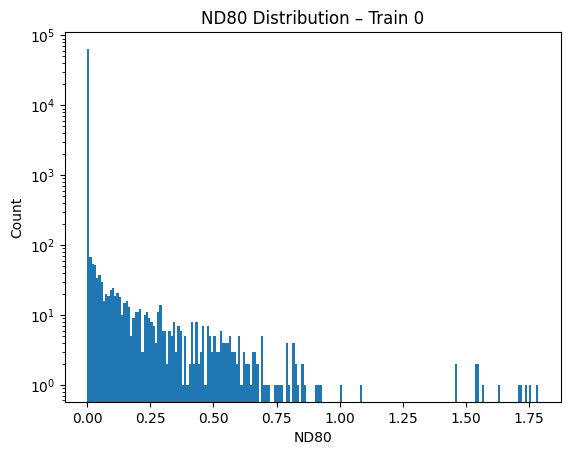

In [11]:
import matplotlib.pyplot as plt

plt.hist(df["ND80"], bins=200)
plt.yscale("log")
plt.xlabel("ND80")
plt.ylabel("Count")
plt.title("ND80 Distribution – Train 0")
plt.show()
